# <center> Предсказание победителя в Dota 2
<center> <img src="https://meduza.io/impro/YnJZAHUW6WHz_JQm1uRPkTql_qAhbfxt3oFJLGH7CJg/fill/980/0/ce/1/aHR0cHM6Ly9tZWR1/emEuaW8vaW1hZ2Uv/YXR0YWNobWVudHMv/aW1hZ2VzLzAwNy8x/NTcvNjk1L29yaWdp/bmFsL0tMVThLbUti/ZG5pSzlibDA0Wmlw/WXcuanBn.webp" width="700" height="700">

[Почитать подбробнее](https://meduza.io/feature/2021/10/19/rossiyskaya-komanda-vyigrala-chempionat-mira-po-dota-2-i-poluchila-18-millionov-dollarov-postoyte-otkuda-takie-dengi-neuzheli-igrat-v-dotu-tak-slozhno)

#### [Оригинальная статья](https://arxiv.org/pdf/2106.01782.pdf)
    
### Начало

Посмотрим на готовые признаки и сделаем первую посылку. 

1. [Описание данных](#Описание-данных)
2. [Описание признаков](#Описание-признаков)
3. [Наша первая модель](#Наша-первая-модель)
4. [Посылка](#Посылка)

### Первые шаги на пути в датасайенс

5. [Кросс-валидация](#Кросс-валидация)
6. [Что есть в json файлах?](#Что-есть-в-json-файлах?)
7. [Feature engineering](#Feature-engineering)

### Мое решение
8. [CatBoost ](#CatBoost)
9. [Parameter Tuning for CatBoost](#Parameter-Tuning-for-CatBoost)
10. [Feature engineering](#Feature-engineering)
11. [Final model](#Final-model)


### Импорты

In [164]:
import os
import json
import pandas as pd
import numpy as np
import datetime
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, make_scorer

# Classifiers
from catboost import CatBoostClassifier

# Model selection
from sklearn.model_selection import StratifiedKFold

from sklearn.model_selection import GridSearchCV

%matplotlib inline

In [2]:
SEED = 10801
sns.set_style(style="whitegrid")
plt.rcParams["figure.figsize"] = 12, 8
warnings.filterwarnings("ignore")

## <left>Описание данных

Файлы:

- `sample_submission.csv`: пример файла-посылки
- `train_raw_data.jsonl`, `test_raw_data.jsonl`: "сырые" данные 
- `train_data.csv`, `test_data.csv`: признаки, созданные авторами
- `train_targets.csv`: результаты тренировочных игр

## <left>Описание признаков
    
Набор простых признаков, описывающих игроков и команды в целом

In [3]:
PATH_TO_DATA = "C:\\Users\\Roman\\Desktop\\IB\\kaggle"

df_train_features = pd.read_csv(os.path.join(PATH_TO_DATA, 
                                             "train_data.csv"), 
                                    index_col="match_id_hash")
df_train_targets = pd.read_csv(os.path.join(PATH_TO_DATA, 
                                            "train_targets.csv"), 
                                   index_col="match_id_hash")

In [4]:
df_train_features.shape

(31698, 245)

In [7]:
df_train_features.head()

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_kills,r1_deaths,r1_assists,r1_denies,...,d5_stuns,d5_creeps_stacked,d5_camps_stacked,d5_rune_pickups,d5_firstblood_claimed,d5_teamfight_participation,d5_towers_killed,d5_roshans_killed,d5_obs_placed,d5_sen_placed
match_id_hash,,,,,,,,,,,,,,,,,,,,,
b9c57c450ce74a2af79c9ce96fac144d,658,4,0,3,10,15,7,2,0,7,...,0.000000,0,0,0,0,0.00,0,0,0,0
6db558535151ea18ca70a6892197db41,21,23,0,0,0,101,0,0,0,0,...,0.000000,0,0,0,0,0.00,0,0,0,0
19c39fe2af2b547e48708ca005c6ae74,160,22,7,0,0,57,0,0,0,1,...,0.000000,0,0,0,0,0.00,0,0,0,0
c96d629dc0c39f0c616d1949938a6ba6,1016,22,0,1,0,119,0,3,3,5,...,8.264696,0,0,3,0,0.25,0,0,3,0
156c88bff4e9c4668b0f53df3d870f1b,582,22,7,2,2,12,3,1,2,9,...,15.762911,3,1,0,1,0.50,0,0,3,0


Имеем ~32 тысячи наблюдений, каждое из которых характеризуется уникальным `match_id_hash` (захэшированное id матча), и 245 признаков. `game_time` показывает момент времени, в который получены эти данные. То есть по сути это не длительность самого матча, а например, его середина, таким образом, в итоге мы сможем получить модель, которая будет предсказывать вероятность победы каждой из команд в течение матча (хорошо подходит для букмекеров).

Нас интересует поле `radiant_win` (так называется одна из команд, вторая - dire). Остальные колоки здесь по сути получены из "будущего" и есть только для тренировочных данных, поэтому на них можно просто посмотреть).

In [8]:
df_train_targets.head()

,game_time,radiant_win,duration,time_remaining,next_roshan_team
match_id_hash,,,,,
b9c57c450ce74a2af79c9ce96fac144d,658,True,1154,496,NaN
6db558535151ea18ca70a6892197db41,21,True,1503,1482,Radiant
19c39fe2af2b547e48708ca005c6ae74,160,False,2063,1903,NaN
c96d629dc0c39f0c616d1949938a6ba6,1016,True,2147,1131,Radiant
156c88bff4e9c4668b0f53df3d870f1b,582,False,1927,1345,Dire


In [152]:
for col in df_train_targets.columns:
    if df_train_targets[col].isnull().any():
        print(col, df_train_targets[col].isnull().sum())

next_roshan_team 11508


## <left>Наша первая модель

In [12]:
X = df_train_features.values
y = df_train_targets["radiant_win"].values.astype("int8")

In [11]:
X

array([[6.580e+02, 4.000e+00, 0.000e+00, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [2.100e+01, 2.300e+01, 0.000e+00, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [1.600e+02, 2.200e+01, 7.000e+00, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       ...,
       [1.002e+03, 4.000e+00, 0.000e+00, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [3.770e+02, 2.200e+01, 7.000e+00, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [6.430e+02, 2.200e+01, 7.000e+00, ..., 0.000e+00, 1.000e+00,
        0.000e+00]])

In [13]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, 
                                                      test_size=0.3, 
                                                      random_state=SEED)

#### Обучим случайный лес

In [14]:
%%time
rf_model = RandomForestClassifier(n_estimators=300, max_depth=7, n_jobs=-1, random_state=SEED)
rf_model.fit(X_train, y_train)

CPU times: total: 35.5 s
Wall time: 9.18 s


RandomForestClassifier(max_depth=7, n_estimators=300, n_jobs=-1,
                       random_state=10801)

In [66]:
cb_model = CatBoostClassifier(random_state=SEED)

# you can try changing number of trees, depth and learning rate
# model = CatBoostRegressor(iterations=2000, learning_rate=0.05, depth=4, n_cat_features=["sex"])

cb_model.fit(X_train, y_train)

Learning rate set to 0.038701
0:	learn: 0.6876801	total: 50.9ms	remaining: 50.8s
1:	learn: 0.6829614	total: 98ms	remaining: 48.9s
2:	learn: 0.6778586	total: 146ms	remaining: 48.7s
3:	learn: 0.6728173	total: 198ms	remaining: 49.4s
4:	learn: 0.6683887	total: 262ms	remaining: 52.2s
5:	learn: 0.6639862	total: 313ms	remaining: 51.8s
6:	learn: 0.6598543	total: 361ms	remaining: 51.2s
7:	learn: 0.6559224	total: 407ms	remaining: 50.4s
8:	learn: 0.6521547	total: 450ms	remaining: 49.6s
9:	learn: 0.6485736	total: 510ms	remaining: 50.5s
10:	learn: 0.6451347	total: 558ms	remaining: 50.1s
11:	learn: 0.6422579	total: 605ms	remaining: 49.8s
12:	learn: 0.6393984	total: 646ms	remaining: 49s
13:	learn: 0.6370343	total: 688ms	remaining: 48.5s
14:	learn: 0.6343730	total: 746ms	remaining: 49s
15:	learn: 0.6316619	total: 797ms	remaining: 49s
16:	learn: 0.6288582	total: 847ms	remaining: 49s
17:	learn: 0.6264299	total: 892ms	remaining: 48.6s
18:	learn: 0.6241236	total: 942ms	remaining: 48.6s
19:	learn: 0.622037

163:	learn: 0.5334170	total: 7.89s	remaining: 40.2s
164:	learn: 0.5331623	total: 7.96s	remaining: 40.3s
165:	learn: 0.5328916	total: 8.03s	remaining: 40.3s
166:	learn: 0.5326343	total: 8.09s	remaining: 40.4s
167:	learn: 0.5324242	total: 8.17s	remaining: 40.5s
168:	learn: 0.5321955	total: 8.22s	remaining: 40.4s
169:	learn: 0.5319555	total: 8.26s	remaining: 40.3s
170:	learn: 0.5317749	total: 8.3s	remaining: 40.3s
171:	learn: 0.5316182	total: 8.35s	remaining: 40.2s
172:	learn: 0.5314160	total: 8.39s	remaining: 40.1s
173:	learn: 0.5311844	total: 8.44s	remaining: 40s
174:	learn: 0.5309409	total: 8.47s	remaining: 39.9s
175:	learn: 0.5307343	total: 8.53s	remaining: 39.9s
176:	learn: 0.5305377	total: 8.59s	remaining: 39.9s
177:	learn: 0.5303320	total: 8.66s	remaining: 40s
178:	learn: 0.5301074	total: 8.71s	remaining: 40s
179:	learn: 0.5298591	total: 8.75s	remaining: 39.9s
180:	learn: 0.5295753	total: 8.79s	remaining: 39.8s
181:	learn: 0.5293607	total: 8.83s	remaining: 39.7s
182:	learn: 0.52907

327:	learn: 0.4946358	total: 15.7s	remaining: 32.1s
328:	learn: 0.4943315	total: 15.7s	remaining: 32s
329:	learn: 0.4940788	total: 15.7s	remaining: 32s
330:	learn: 0.4938013	total: 15.8s	remaining: 31.9s
331:	learn: 0.4935153	total: 15.8s	remaining: 31.9s
332:	learn: 0.4933146	total: 15.9s	remaining: 31.8s
333:	learn: 0.4931112	total: 15.9s	remaining: 31.7s
334:	learn: 0.4929407	total: 16s	remaining: 31.7s
335:	learn: 0.4927100	total: 16s	remaining: 31.6s
336:	learn: 0.4924625	total: 16s	remaining: 31.5s
337:	learn: 0.4922089	total: 16.1s	remaining: 31.5s
338:	learn: 0.4919486	total: 16.1s	remaining: 31.4s
339:	learn: 0.4916480	total: 16.1s	remaining: 31.4s
340:	learn: 0.4914093	total: 16.2s	remaining: 31.3s
341:	learn: 0.4911772	total: 16.2s	remaining: 31.2s
342:	learn: 0.4909127	total: 16.3s	remaining: 31.2s
343:	learn: 0.4907244	total: 16.3s	remaining: 31.1s
344:	learn: 0.4905304	total: 16.3s	remaining: 31s
345:	learn: 0.4903003	total: 16.4s	remaining: 31s
346:	learn: 0.4900340	tota

487:	learn: 0.4599698	total: 23s	remaining: 24.1s
488:	learn: 0.4597754	total: 23s	remaining: 24.1s
489:	learn: 0.4596123	total: 23.1s	remaining: 24s
490:	learn: 0.4593924	total: 23.1s	remaining: 23.9s
491:	learn: 0.4591981	total: 23.1s	remaining: 23.9s
492:	learn: 0.4589527	total: 23.2s	remaining: 23.9s
493:	learn: 0.4587931	total: 23.2s	remaining: 23.8s
494:	learn: 0.4586365	total: 23.3s	remaining: 23.8s
495:	learn: 0.4584162	total: 23.3s	remaining: 23.7s
496:	learn: 0.4581577	total: 23.4s	remaining: 23.7s
497:	learn: 0.4579352	total: 23.4s	remaining: 23.6s
498:	learn: 0.4576831	total: 23.5s	remaining: 23.6s
499:	learn: 0.4575941	total: 23.5s	remaining: 23.5s
500:	learn: 0.4574400	total: 23.5s	remaining: 23.4s
501:	learn: 0.4572335	total: 23.6s	remaining: 23.4s
502:	learn: 0.4570908	total: 23.6s	remaining: 23.3s
503:	learn: 0.4569403	total: 23.6s	remaining: 23.3s
504:	learn: 0.4567602	total: 23.7s	remaining: 23.2s
505:	learn: 0.4565396	total: 23.7s	remaining: 23.2s
506:	learn: 0.4563

649:	learn: 0.4302469	total: 30.2s	remaining: 16.3s
650:	learn: 0.4300316	total: 30.2s	remaining: 16.2s
651:	learn: 0.4298441	total: 30.3s	remaining: 16.2s
652:	learn: 0.4296416	total: 30.3s	remaining: 16.1s
653:	learn: 0.4294561	total: 30.4s	remaining: 16.1s
654:	learn: 0.4293398	total: 30.4s	remaining: 16s
655:	learn: 0.4291982	total: 30.5s	remaining: 16s
656:	learn: 0.4290729	total: 30.5s	remaining: 15.9s
657:	learn: 0.4288532	total: 30.5s	remaining: 15.9s
658:	learn: 0.4286193	total: 30.6s	remaining: 15.8s
659:	learn: 0.4284487	total: 30.6s	remaining: 15.8s
660:	learn: 0.4283264	total: 30.7s	remaining: 15.7s
661:	learn: 0.4282036	total: 30.7s	remaining: 15.7s
662:	learn: 0.4280531	total: 30.7s	remaining: 15.6s
663:	learn: 0.4278427	total: 30.8s	remaining: 15.6s
664:	learn: 0.4276235	total: 30.8s	remaining: 15.5s
665:	learn: 0.4274604	total: 30.9s	remaining: 15.5s
666:	learn: 0.4273069	total: 30.9s	remaining: 15.4s
667:	learn: 0.4271175	total: 31s	remaining: 15.4s
668:	learn: 0.4269

809:	learn: 0.4044855	total: 37s	remaining: 8.67s
810:	learn: 0.4043601	total: 37s	remaining: 8.62s
811:	learn: 0.4043489	total: 37s	remaining: 8.57s
812:	learn: 0.4042481	total: 37.1s	remaining: 8.52s
813:	learn: 0.4040507	total: 37.1s	remaining: 8.48s
814:	learn: 0.4038882	total: 37.1s	remaining: 8.43s
815:	learn: 0.4037060	total: 37.2s	remaining: 8.38s
816:	learn: 0.4034958	total: 37.2s	remaining: 8.34s
817:	learn: 0.4033771	total: 37.3s	remaining: 8.29s
818:	learn: 0.4031935	total: 37.3s	remaining: 8.24s
819:	learn: 0.4030112	total: 37.4s	remaining: 8.2s
820:	learn: 0.4028814	total: 37.4s	remaining: 8.15s
821:	learn: 0.4027722	total: 37.4s	remaining: 8.11s
822:	learn: 0.4026229	total: 37.5s	remaining: 8.06s
823:	learn: 0.4024763	total: 37.5s	remaining: 8.01s
824:	learn: 0.4023692	total: 37.6s	remaining: 7.96s
825:	learn: 0.4022299	total: 37.6s	remaining: 7.92s
826:	learn: 0.4020879	total: 37.6s	remaining: 7.87s
827:	learn: 0.4019390	total: 37.7s	remaining: 7.83s
828:	learn: 0.40181

973:	learn: 0.3814745	total: 43.5s	remaining: 1.16s
974:	learn: 0.3813052	total: 43.6s	remaining: 1.12s
975:	learn: 0.3811555	total: 43.6s	remaining: 1.07s
976:	learn: 0.3810605	total: 43.6s	remaining: 1.03s
977:	learn: 0.3809685	total: 43.7s	remaining: 983ms
978:	learn: 0.3808234	total: 43.7s	remaining: 938ms
979:	learn: 0.3806323	total: 43.8s	remaining: 893ms
980:	learn: 0.3804575	total: 43.8s	remaining: 849ms
981:	learn: 0.3803533	total: 43.9s	remaining: 804ms
982:	learn: 0.3801875	total: 43.9s	remaining: 759ms
983:	learn: 0.3800393	total: 43.9s	remaining: 714ms
984:	learn: 0.3799542	total: 44s	remaining: 670ms
985:	learn: 0.3798050	total: 44s	remaining: 625ms
986:	learn: 0.3796786	total: 44.1s	remaining: 580ms
987:	learn: 0.3795440	total: 44.1s	remaining: 536ms
988:	learn: 0.3793956	total: 44.1s	remaining: 491ms
989:	learn: 0.3792685	total: 44.2s	remaining: 446ms
990:	learn: 0.3791705	total: 44.2s	remaining: 402ms
991:	learn: 0.3791611	total: 44.2s	remaining: 357ms
992:	learn: 0.37

#### Сделаем предсказания и оценим качество на отложенной части данных

In [15]:
y_pred = rf_model.predict_proba(X_valid)[:, 1]

In [20]:
rf_model.predict_proba(X_valid)

array([[0.34528604, 0.65471396],
       [0.45380075, 0.54619925],
       [0.63386595, 0.36613405],
       ...,
       [0.42106174, 0.57893826],
       [0.56841546, 0.43158454],
       [0.39137957, 0.60862043]])

In [21]:
valid_score = roc_auc_score(y_valid, y_pred)
print("ROC-AUC score на отложенной части:", valid_score)

ROC-AUC score на отложенной части: 0.7754387258058622


Посмотрим на accuracy:

In [22]:
valid_accuracy = accuracy_score(y_valid, y_pred > 0.5)
print("Accuracy score (p > 0.5) на отложенной части:", valid_accuracy)

Accuracy score (p > 0.5) на отложенной части: 0.6885383806519453


## <left>Посылка

In [23]:
df_test_features = pd.read_csv(os.path.join(PATH_TO_DATA, "test_data.csv"), 
                                   index_col="match_id_hash")

X_test = df_test_features.values
y_test_pred = rf_model.predict_proba(X_test)[:, 1]

df_submission = pd.DataFrame({"radiant_win_prob": y_test_pred}, 
                                 index=df_test_features.index)

In [24]:
submission_filename = "submission_{}.csv".format(
    datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))
df_submission.to_csv(submission_filename)
print("Файл посылки сохранен, как: {}".format(submission_filename))

Файл посылки сохранен, как: submission_2023-04-09_21-53-43.csv


## <left>Кросс-валидация

Во многих случаях кросс-валидация оказывается лучше простого разбиения на test и train. Воспользуемся `ShuffleSplit` чтобы создать 5 70%/30% наборов данных.

In [56]:
cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=SEED)

In [26]:
%%time
rf_model = RandomForestClassifier(n_estimators=300, max_depth=7, n_jobs=-1, random_state=SEED)
cv_scores_rf = cross_val_score(rf_model, X, y, cv=cv, scoring="roc_auc")

CPU times: total: 8.77 s
Wall time: 1min 1s


In [27]:
cv_scores_rf

array([0.77543873, 0.77343884, 0.76649967, 0.7722681 , 0.77246001])

In [28]:
print(f"Среднее значение ROC-AUC на кросс-валидации: {cv_scores_rf.mean()}")

Среднее значение ROC-AUC на кросс-валидации: 0.7720210676055513


## <left>Что есть в json файлах?

Описание сырых данных можно найти в `train_matches.jsonl` и `test_matches.jsonl`. Каждый файл содержит одну запись для каждого матча в [JSON](https://en.wikipedia.org/wiki/JSON) формате. Его легко превратить в питоновский объект при помощи метода `json.loads`.

In [30]:
with open(os.path.join(PATH_TO_DATA, "train_raw_data.jsonl")) as fin:
    # прочтем 419 строку
    for i in range(419):
        line = fin.readline()
    
    # переведем JSON в питоновский словарь 
    match = json.loads(line)

In [31]:
player = match["players"][9]
player["kills"], player["deaths"], player["assists"]

(0, 5, 5)

KDA - может быть неплохим признаком, этот показатель считается как:
    
<center>$KDA = \frac{K + A}{D}$

Информация о количестве использованных способностей:

In [37]:
player["ability_uses"]

{'treant_living_armor': 52, 'treant_leech_seed': 5, 'treant_overgrowth': 5}

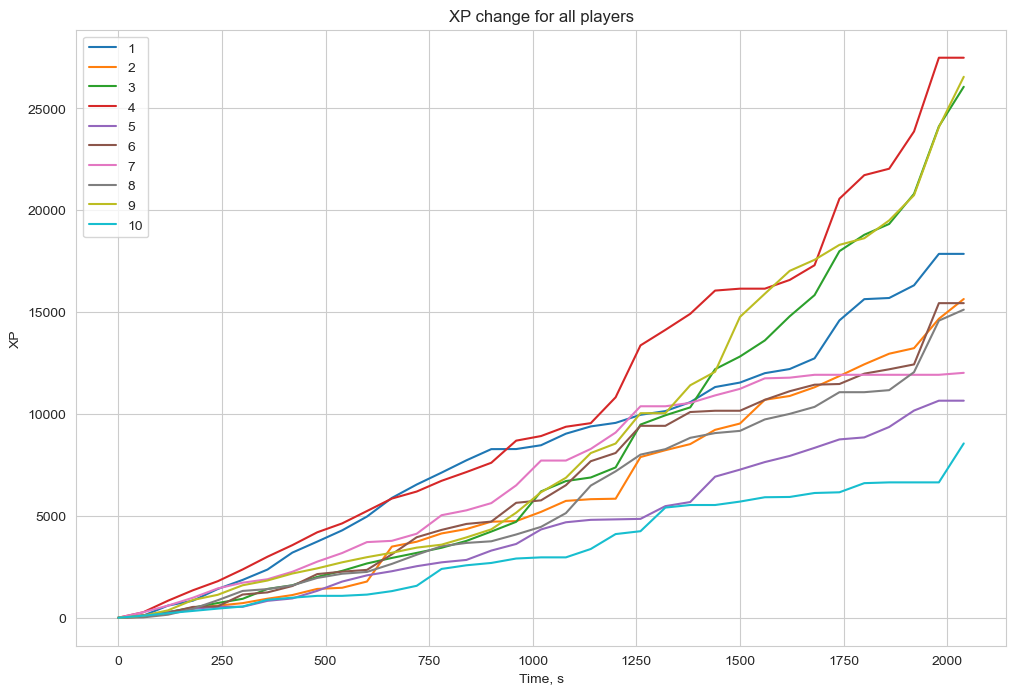

In [38]:
for i, player in enumerate(match["players"]):
    plt.plot(player["times"], player["xp_t"], label=str(i+1))

plt.legend()
plt.xlabel("Time, s")
plt.ylabel("XP")
plt.title("XP change for all players");

#### Сделаем чтение файла с сырыми данными и добавление новых признаков удобным

В этот раз для чтение `json` файлов лучше использовать библиотеку `ujson`, иначе все будет слишком долго :(

In [39]:
try:
    import ujson as json
except ModuleNotFoundError:
    import json
    print ("Подумайте об установке ujson, чтобы работать с JSON объектами быстрее")
    
try:
    from tqdm.notebook import tqdm
except ModuleNotFoundError:
    tqdm_notebook = lambda x: x
    print ("Подумайте об установке tqdm, чтобы следить за прогрессом")

    
def read_matches(matches_file, total_matches=31698, n_matches_to_read=None):
    """
    Аргумент
    -------
    matches_file: JSON файл с сырыми данными
    
    Результат
    ---------
    Возвращает записи о каждом матче
    """
    
    if n_matches_to_read is None:
        n_matches_to_read = total_matches
        
    c = 0
    with open(matches_file) as fin:
        for line in tqdm(fin, total=total_matches):
            if c >= n_matches_to_read:
                break
            else:
                c += 1
                yield json.loads(line)

#### Чтение данных в цикле

Чтение всех данных занимает 1-2 минуты, поэтому для начала можно попробовать следующее:

1. Читать 10-50 игр
2. Написать код для работы с этими JSON объектами
3. Убедиться, что все работает
4. Запустить код на всем датасете
5. Сохранить результат в `pickle` файл, чтобы в следующий раз не переделывать все заново

## <left>Feature engineering

Напишем функцию, которая поможет нам легче добавлять новые признаки.

In [40]:
def add_new_features(df_features, matches_file):
    """
    Аргуенты
    -------
    df_features: таблица с данными
    matches_file: JSON файл с сырыми данными
    
    Результат
    ---------
    Добавляет новые признаки в таблицу
    """
    
    for match in read_matches(matches_file):
        match_id_hash = match['match_id_hash']

        # Посчитаем количество разрушенных вышек обеими командами
        radiant_tower_kills = 0
        dire_tower_kills = 0
        for objective in match["objectives"]:
            if objective["type"] == "CHAT_MESSAGE_TOWER_KILL":
                if objective["team"] == 2:
                    radiant_tower_kills += 1
                if objective["team"] == 3:
                    dire_tower_kills += 1

        df_features.loc[match_id_hash, "radiant_tower_kills"] = radiant_tower_kills
        df_features.loc[match_id_hash, "dire_tower_kills"] = dire_tower_kills
        df_features.loc[match_id_hash, "diff_tower_kills"] = radiant_tower_kills - dire_tower_kills
        
        # ... (/¯◡ ‿ ◡)/¯☆*:・ﾟ добавляем новые признаки ...

In [41]:
# Скопируем таблицу с признаками
df_train_features_extended = df_train_features.copy()

# Добавим новые
add_new_features(df_train_features_extended, 
                 os.path.join(PATH_TO_DATA, 
                              "train_raw_data.jsonl"))

  0%|          | 0/31698 [00:00<?, ?it/s]

In [42]:
df_train_features_extended.head()

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_kills,r1_deaths,r1_assists,r1_denies,...,d5_rune_pickups,d5_firstblood_claimed,d5_teamfight_participation,d5_towers_killed,d5_roshans_killed,d5_obs_placed,d5_sen_placed,radiant_tower_kills,dire_tower_kills,diff_tower_kills
match_id_hash,,,,,,,,,,,,,,,,,,,,,
b9c57c450ce74a2af79c9ce96fac144d,658,4,0,3,10,15,7,2,0,7,...,0,0,0.00,0,0,0,0,2.0,0.0,2.0
6db558535151ea18ca70a6892197db41,21,23,0,0,0,101,0,0,0,0,...,0,0,0.00,0,0,0,0,0.0,0.0,0.0
19c39fe2af2b547e48708ca005c6ae74,160,22,7,0,0,57,0,0,0,1,...,0,0,0.00,0,0,0,0,0.0,0.0,0.0
c96d629dc0c39f0c616d1949938a6ba6,1016,22,0,1,0,119,0,3,3,5,...,3,0,0.25,0,0,3,0,0.0,0.0,0.0
156c88bff4e9c4668b0f53df3d870f1b,582,22,7,2,2,12,3,1,2,9,...,0,1,0.50,0,0,3,0,0.0,1.0,-1.0


In [70]:
df_train_features_extended.shape

(31698, 248)

In [84]:
df_train_features.shape

(31698, 245)

In [43]:
%%time
cv_scores_base = cross_val_score(rf_model, X, y, cv=cv, scoring="roc_auc", n_jobs=-1)
cv_scores_extended = cross_val_score(rf_model, df_train_features_extended.values, y, 
                                     cv=cv, scoring="roc_auc", n_jobs=-1)

CPU times: total: 188 ms
Wall time: 1min 36s


In [44]:
print(f"ROC-AUC на кросс-валидации для базовых признаков: {cv_scores_base.mean()}")
print(f"ROC-AUC на кросс-валидации для новых признаков: {cv_scores_extended.mean()}")

ROC-AUC на кросс-валидации для базовых признаков: 0.7720210676055513
ROC-AUC на кросс-валидации для новых признаков: 0.778796825263235


Видно, что случайный лес стал работать немного лучше при добавлении новых признаков. A еще нужно, наверное, как-то по-умному закодировать категориальные признаки.

Дальше дело за малым. Добавляйте новые признаки, пробуйте другие методы, которые мы изучили, а также что-то интересное, что мы не прошли. Удачи!

### <left>Я попробую мой любимый градиентный бустинг - CatBoost

## <left>CatBoost 

Тренирую модель сразу на extended_features

In [71]:
cb_model = CatBoostClassifier(random_state=SEED)

# you can try changing number of trees, depth and learning rate
# model = CatBoostRegressor(iterations=2000, learning_rate=0.05, depth=4, n_cat_features=["sex"])

cb_model.fit(df_train_features_extended.values, y)

Learning rate set to 0.045069
0:	learn: 0.6834105	total: 51.8ms	remaining: 51.7s
1:	learn: 0.6740971	total: 97.4ms	remaining: 48.6s
2:	learn: 0.6658316	total: 146ms	remaining: 48.5s
3:	learn: 0.6582251	total: 196ms	remaining: 48.7s
4:	learn: 0.6509513	total: 256ms	remaining: 51s
5:	learn: 0.6451187	total: 305ms	remaining: 50.6s
6:	learn: 0.6396322	total: 348ms	remaining: 49.3s
7:	learn: 0.6343511	total: 399ms	remaining: 49.5s
8:	learn: 0.6291469	total: 446ms	remaining: 49.2s
9:	learn: 0.6249573	total: 501ms	remaining: 49.6s
10:	learn: 0.6212222	total: 552ms	remaining: 49.6s
11:	learn: 0.6174182	total: 604ms	remaining: 49.8s
12:	learn: 0.6141242	total: 673ms	remaining: 51.1s
13:	learn: 0.6111645	total: 728ms	remaining: 51.3s
14:	learn: 0.6082415	total: 799ms	remaining: 52.5s
15:	learn: 0.6055099	total: 851ms	remaining: 52.3s
16:	learn: 0.6032013	total: 921ms	remaining: 53.3s
17:	learn: 0.6005775	total: 985ms	remaining: 53.7s
18:	learn: 0.5984195	total: 1.04s	remaining: 53.6s
19:	learn: 

162:	learn: 0.5247122	total: 8.67s	remaining: 44.5s
163:	learn: 0.5244772	total: 8.71s	remaining: 44.4s
164:	learn: 0.5242329	total: 8.77s	remaining: 44.4s
165:	learn: 0.5240096	total: 8.82s	remaining: 44.3s
166:	learn: 0.5238358	total: 8.86s	remaining: 44.2s
167:	learn: 0.5236631	total: 8.92s	remaining: 44.2s
168:	learn: 0.5234299	total: 8.97s	remaining: 44.1s
169:	learn: 0.5232679	total: 9.01s	remaining: 44s
170:	learn: 0.5230989	total: 9.06s	remaining: 43.9s
171:	learn: 0.5228950	total: 9.11s	remaining: 43.8s
172:	learn: 0.5226839	total: 9.16s	remaining: 43.8s
173:	learn: 0.5224841	total: 9.21s	remaining: 43.7s
174:	learn: 0.5222637	total: 9.26s	remaining: 43.6s
175:	learn: 0.5220747	total: 9.3s	remaining: 43.5s
176:	learn: 0.5218806	total: 9.35s	remaining: 43.5s
177:	learn: 0.5216919	total: 9.4s	remaining: 43.4s
178:	learn: 0.5214413	total: 9.46s	remaining: 43.4s
179:	learn: 0.5211729	total: 9.51s	remaining: 43.3s
180:	learn: 0.5210433	total: 9.55s	remaining: 43.2s
181:	learn: 0.52

322:	learn: 0.4917663	total: 16.5s	remaining: 34.6s
323:	learn: 0.4915599	total: 16.6s	remaining: 34.6s
324:	learn: 0.4913291	total: 16.6s	remaining: 34.5s
325:	learn: 0.4910943	total: 16.7s	remaining: 34.5s
326:	learn: 0.4908592	total: 16.7s	remaining: 34.4s
327:	learn: 0.4906933	total: 16.8s	remaining: 34.4s
328:	learn: 0.4904597	total: 16.8s	remaining: 34.3s
329:	learn: 0.4903039	total: 16.9s	remaining: 34.3s
330:	learn: 0.4901150	total: 16.9s	remaining: 34.2s
331:	learn: 0.4899725	total: 17s	remaining: 34.1s
332:	learn: 0.4897436	total: 17s	remaining: 34.1s
333:	learn: 0.4896286	total: 17.1s	remaining: 34s
334:	learn: 0.4894547	total: 17.1s	remaining: 33.9s
335:	learn: 0.4892209	total: 17.2s	remaining: 33.9s
336:	learn: 0.4889734	total: 17.2s	remaining: 33.8s
337:	learn: 0.4887407	total: 17.3s	remaining: 33.8s
338:	learn: 0.4884998	total: 17.3s	remaining: 33.7s
339:	learn: 0.4882941	total: 17.4s	remaining: 33.7s
340:	learn: 0.4880585	total: 17.4s	remaining: 33.6s
341:	learn: 0.4878

483:	learn: 0.4627175	total: 25s	remaining: 26.6s
484:	learn: 0.4625091	total: 25s	remaining: 26.6s
485:	learn: 0.4623037	total: 25.1s	remaining: 26.5s
486:	learn: 0.4621423	total: 25.1s	remaining: 26.5s
487:	learn: 0.4619600	total: 25.2s	remaining: 26.4s
488:	learn: 0.4617991	total: 25.2s	remaining: 26.4s
489:	learn: 0.4616470	total: 25.3s	remaining: 26.3s
490:	learn: 0.4614833	total: 25.3s	remaining: 26.2s
491:	learn: 0.4613010	total: 25.4s	remaining: 26.2s
492:	learn: 0.4610934	total: 25.4s	remaining: 26.1s
493:	learn: 0.4609906	total: 25.5s	remaining: 26.1s
494:	learn: 0.4608109	total: 25.5s	remaining: 26s
495:	learn: 0.4606320	total: 25.6s	remaining: 26s
496:	learn: 0.4605226	total: 25.6s	remaining: 25.9s
497:	learn: 0.4603849	total: 25.6s	remaining: 25.8s
498:	learn: 0.4601899	total: 25.7s	remaining: 25.8s
499:	learn: 0.4600491	total: 25.8s	remaining: 25.8s
500:	learn: 0.4598884	total: 25.8s	remaining: 25.7s
501:	learn: 0.4597336	total: 25.8s	remaining: 25.6s
502:	learn: 0.459566

646:	learn: 0.4371096	total: 33.8s	remaining: 18.4s
647:	learn: 0.4369150	total: 33.8s	remaining: 18.4s
648:	learn: 0.4367719	total: 33.9s	remaining: 18.3s
649:	learn: 0.4366254	total: 33.9s	remaining: 18.3s
650:	learn: 0.4364608	total: 34s	remaining: 18.2s
651:	learn: 0.4363110	total: 34s	remaining: 18.2s
652:	learn: 0.4362081	total: 34.1s	remaining: 18.1s
653:	learn: 0.4360519	total: 34.1s	remaining: 18.1s
654:	learn: 0.4358688	total: 34.2s	remaining: 18s
655:	learn: 0.4357323	total: 34.2s	remaining: 17.9s
656:	learn: 0.4355756	total: 34.3s	remaining: 17.9s
657:	learn: 0.4353892	total: 34.3s	remaining: 17.8s
658:	learn: 0.4353251	total: 34.4s	remaining: 17.8s
659:	learn: 0.4351598	total: 34.4s	remaining: 17.7s
660:	learn: 0.4350030	total: 34.5s	remaining: 17.7s
661:	learn: 0.4348583	total: 34.5s	remaining: 17.6s
662:	learn: 0.4346840	total: 34.6s	remaining: 17.6s
663:	learn: 0.4345544	total: 34.6s	remaining: 17.5s
664:	learn: 0.4343969	total: 34.7s	remaining: 17.5s
665:	learn: 0.4342

805:	learn: 0.4154042	total: 41.6s	remaining: 10s
806:	learn: 0.4152869	total: 41.7s	remaining: 9.97s
807:	learn: 0.4151562	total: 41.7s	remaining: 9.91s
808:	learn: 0.4151250	total: 41.8s	remaining: 9.86s
809:	learn: 0.4150273	total: 41.8s	remaining: 9.81s
810:	learn: 0.4150182	total: 41.8s	remaining: 9.75s
811:	learn: 0.4148476	total: 41.9s	remaining: 9.7s
812:	learn: 0.4146898	total: 41.9s	remaining: 9.65s
813:	learn: 0.4145561	total: 42s	remaining: 9.59s
814:	learn: 0.4144773	total: 42s	remaining: 9.54s
815:	learn: 0.4143556	total: 42.1s	remaining: 9.49s
816:	learn: 0.4141888	total: 42.1s	remaining: 9.44s
817:	learn: 0.4140259	total: 42.2s	remaining: 9.38s
818:	learn: 0.4138757	total: 42.2s	remaining: 9.33s
819:	learn: 0.4137275	total: 42.3s	remaining: 9.28s
820:	learn: 0.4136491	total: 42.3s	remaining: 9.23s
821:	learn: 0.4135457	total: 42.4s	remaining: 9.17s
822:	learn: 0.4134111	total: 42.4s	remaining: 9.12s
823:	learn: 0.4132886	total: 42.5s	remaining: 9.07s
824:	learn: 0.41313

968:	learn: 0.3956086	total: 50.5s	remaining: 1.61s
969:	learn: 0.3955022	total: 50.5s	remaining: 1.56s
970:	learn: 0.3953916	total: 50.6s	remaining: 1.51s
971:	learn: 0.3952554	total: 50.6s	remaining: 1.46s
972:	learn: 0.3951444	total: 50.7s	remaining: 1.41s
973:	learn: 0.3950227	total: 50.7s	remaining: 1.35s
974:	learn: 0.3948833	total: 50.8s	remaining: 1.3s
975:	learn: 0.3947972	total: 50.8s	remaining: 1.25s
976:	learn: 0.3946442	total: 50.9s	remaining: 1.2s
977:	learn: 0.3945147	total: 50.9s	remaining: 1.15s
978:	learn: 0.3944158	total: 51s	remaining: 1.09s
979:	learn: 0.3943293	total: 51s	remaining: 1.04s
980:	learn: 0.3941885	total: 51.1s	remaining: 989ms
981:	learn: 0.3940699	total: 51.1s	remaining: 937ms
982:	learn: 0.3939257	total: 51.2s	remaining: 885ms
983:	learn: 0.3938117	total: 51.2s	remaining: 833ms
984:	learn: 0.3937429	total: 51.2s	remaining: 780ms
985:	learn: 0.3936452	total: 51.3s	remaining: 728ms
986:	learn: 0.3935286	total: 51.3s	remaining: 676ms
987:	learn: 0.3933

Кросс-валидация

In [ ]:
%%time
cv_scores_base = cross_val_score(cb_model, X, y, cv=cv, scoring="roc_auc", n_jobs=-1)
cv_scores_extended = cross_val_score(cb_model, df_train_features_extended.values, y, 
                                     cv=cv, scoring="roc_auc", n_jobs=-1)

In [ ]:
print(f"ROC-AUC на кросс-валидации для базовых признаков: {cv_scores_base.mean()}")
print(f"ROC-AUC на кросс-валидации для новых признаков: {cv_scores_extended.mean()}")

### Функция для посылки

In [129]:
def submit_predictions(X_test,model,name):
    df_test_features = pd.read_csv(os.path.join(PATH_TO_DATA, 'test_data.csv'), 
                                   index_col='match_id_hash')
    X_test = X_test
    y_test_pred = model.predict_proba(X_test)[:, 1]

    df_submission = pd.DataFrame({'radiant_win_prob': y_test_pred}, 
                                 index=df_test_features.index)
    submission_filename = 'submission_{}.csv'.format(datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))
    df_submission.to_csv(submission_filename)
    print('Submission saved to {}'.format(submission_filename).format(name))

In [ ]:
# Тестовая таблица с новыми признаками
df_test_features_extended = df_test_features.copy()

# Добавим новые
add_new_features(df_test_features_extended, 
                 os.path.join(PATH_TO_DATA, 
                              "test_raw_data.jsonl"))

## <left>Feature engineering 


Let's vizualize top 50 important features, according to CatBoost

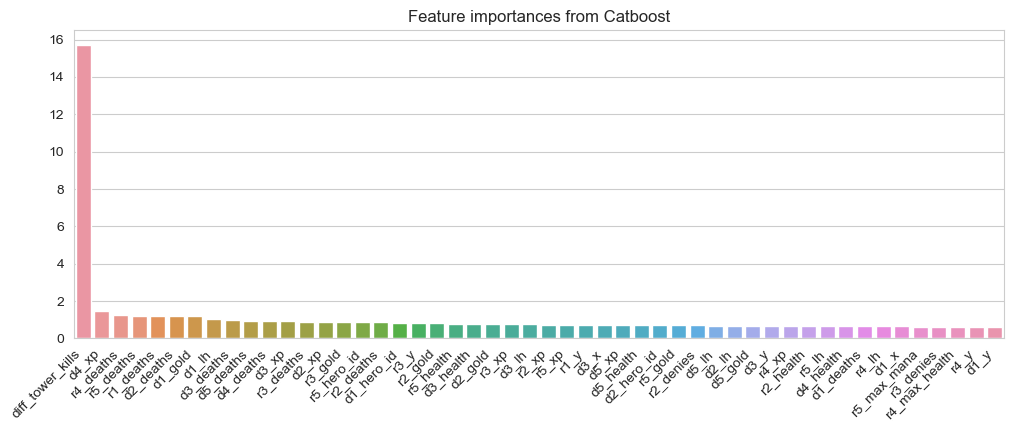

In [180]:
plt.figure(figsize=(12, 4))

indices = np.argsort(-tuned_model.feature_importances_)
feature_names = df_train_features_extended.columns 

sns.barplot(
    x=[feature_names[i] for i in indices][:50], 
    y=tuned_model.feature_importances_[indices][:50]
)
plt.title("Feature importances from Catboost")
plt.xticks(rotation=45, ha="right")
plt.show()

```diff_tower_kills```, calculated as ```radiant_tower_kills - dire_tower_kills```, is the most important one, suggesting that differences in achievements between teams are really informative.

### Ratios of parameters for Teams

The idea was borrowed from Kaggle competitors @artgor and @clair14 (mlcourse.ai: Dota 2 Winner Prediction Competition)

The progress of each player can't give us a lot of information, but maybe the achievements of the whole team are more relevant. Moreover, it is worth checking whether players in a team have similar parameters (by computing std). Let's recalculate the parameters for the whole teams (as sum, mean and std of the parameters of each team member) and then take a ratio (radiant vs dire). 

In [154]:
train = df_train_features_extended.copy()

In [155]:
test = df_test_features_extended.copy()

In [159]:
for c in ['kills', 'deaths', 'assists', 'denies', 'gold', 'lh', 'xp', 'health', 'max_health', 'max_mana', 'level', 'x', 'y', 'stuns', 'creeps_stacked', 'camps_stacked', 'rune_pickups',
          'firstblood_claimed', 'teamfight_participation', 'towers_killed', 'roshans_killed', 'obs_placed', 'sen_placed']:
    r_columns = [f'r{i}_{c}' for i in range(1, 6)]
    d_columns = [f'd{i}_{c}' for i in range(1, 6)]
    
    train['r_total_' + c] = train[r_columns].sum(1)
    train['d_total_' + c] = train[d_columns].sum(1)
    train['total_' + c + '_ratio'] = train['r_total_' + c] / train['d_total_' + c]
    
    test['r_total_' + c] = test[r_columns].sum(1)
    test['d_total_' + c] = test[d_columns].sum(1)
    test['total_' + c + '_ratio'] = test['r_total_' + c] / test['d_total_' + c]
    
    train['r_std_' + c] = train[r_columns].std(1)
    train['d_std_' + c] = train[d_columns].std(1)
    train['std_' + c + '_ratio'] = train['r_std_' + c] / train['d_std_' + c]
    
    test['r_std_' + c] = test[r_columns].std(1)
    test['d_std_' + c] = test[d_columns].std(1)
    test['std_' + c + '_ratio'] = test['r_std_' + c] / test['d_std_' + c]
    
    train['r_mean_' + c] = train[r_columns].mean(1)
    train['d_mean_' + c] = train[d_columns].mean(1)
    train['mean_' + c + '_ratio'] = train['r_mean_' + c] / train['d_mean_' + c]
    
    test['r_mean_' + c] = test[r_columns].mean(1)
    test['d_mean_' + c] = test[d_columns].mean(1)

In [160]:
train.shape, test.shape

((31698, 455), (7977, 455))

In [161]:
train.head()

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_kills,r1_deaths,r1_assists,r1_denies,...,mean_obs_placed_ratio,r_total_sen_placed,d_total_sen_placed,total_sen_placed_ratio,r_std_sen_placed,d_std_sen_placed,std_sen_placed_ratio,r_mean_sen_placed,d_mean_sen_placed,mean_sen_placed_ratio
match_id_hash,,,,,,,,,,,,,,,,,,,,,
b9c57c450ce74a2af79c9ce96fac144d,658,4,0,3,10,15,7,2,0,7,...,0.800000,3,2,1.5,0.894427,0.894427,1.0,0.6,0.4,1.5
6db558535151ea18ca70a6892197db41,21,23,0,0,0,101,0,0,0,0,...,NaN,0,0,NaN,0.000000,0.000000,NaN,0.0,0.0,NaN
19c39fe2af2b547e48708ca005c6ae74,160,22,7,0,0,57,0,0,0,1,...,inf,0,0,NaN,0.000000,0.000000,NaN,0.0,0.0,NaN
c96d629dc0c39f0c616d1949938a6ba6,1016,22,0,1,0,119,0,3,3,5,...,0.857143,2,1,2.0,0.894427,0.447214,2.0,0.4,0.2,2.0
156c88bff4e9c4668b0f53df3d870f1b,582,22,7,2,2,12,3,1,2,9,...,0.500000,0,1,0.0,0.000000,0.447214,0.0,0.0,0.2,0.0


## <left>Parameter Tuning for CatBoost
Попробуем оптимизироваьт параметры, используя GridSearchCV

In [184]:
CBC = CatBoostClassifier(random_state=SEED)



In [185]:
parameters = {'depth'         : [4,5,6,7],
                 'learning_rate' : [0.01, 0.03,0.07],
                  'iterations'    : [10, 50, 100, 200, 300, 400, 500]
                 }

In [186]:
Grid_CBC = GridSearchCV(estimator=CBC, param_grid = parameters, cv = 2, n_jobs=-1)
Grid_CBC.fit(train, y)

0:	learn: 0.6828172	total: 202ms	remaining: 1m
1:	learn: 0.6732625	total: 351ms	remaining: 52.3s
2:	learn: 0.6645537	total: 526ms	remaining: 52.1s
3:	learn: 0.6555134	total: 677ms	remaining: 50.1s
4:	learn: 0.6470926	total: 844ms	remaining: 49.8s
5:	learn: 0.6398322	total: 998ms	remaining: 48.9s
6:	learn: 0.6328148	total: 1.16s	remaining: 48.8s
7:	learn: 0.6259602	total: 1.32s	remaining: 48.4s
8:	learn: 0.6194606	total: 1.48s	remaining: 47.9s
9:	learn: 0.6133017	total: 1.63s	remaining: 47.2s
10:	learn: 0.6077936	total: 1.8s	remaining: 47.4s
11:	learn: 0.6020133	total: 1.95s	remaining: 46.9s
12:	learn: 0.5977235	total: 2.12s	remaining: 46.7s
13:	learn: 0.5933057	total: 2.27s	remaining: 46.5s
14:	learn: 0.5888240	total: 2.44s	remaining: 46.3s
15:	learn: 0.5849096	total: 2.59s	remaining: 45.9s
16:	learn: 0.5808401	total: 2.75s	remaining: 45.8s
17:	learn: 0.5771985	total: 2.9s	remaining: 45.5s
18:	learn: 0.5739181	total: 3.07s	remaining: 45.4s
19:	learn: 0.5709862	total: 3.22s	remaining: 4

162:	learn: 0.4898067	total: 24.5s	remaining: 20.6s
163:	learn: 0.4896676	total: 24.6s	remaining: 20.4s
164:	learn: 0.4895285	total: 24.8s	remaining: 20.3s
165:	learn: 0.4893365	total: 24.9s	remaining: 20.1s
166:	learn: 0.4892002	total: 25.1s	remaining: 20s
167:	learn: 0.4890265	total: 25.2s	remaining: 19.8s
168:	learn: 0.4888899	total: 25.4s	remaining: 19.7s
169:	learn: 0.4887083	total: 25.5s	remaining: 19.5s
170:	learn: 0.4885285	total: 25.6s	remaining: 19.3s
171:	learn: 0.4883880	total: 25.8s	remaining: 19.2s
172:	learn: 0.4881712	total: 25.9s	remaining: 19s
173:	learn: 0.4880208	total: 26.1s	remaining: 18.9s
174:	learn: 0.4878787	total: 26.2s	remaining: 18.7s
175:	learn: 0.4877821	total: 26.3s	remaining: 18.6s
176:	learn: 0.4876805	total: 26.5s	remaining: 18.4s
177:	learn: 0.4875189	total: 26.6s	remaining: 18.2s
178:	learn: 0.4873753	total: 26.7s	remaining: 18.1s
179:	learn: 0.4872242	total: 26.9s	remaining: 17.9s
180:	learn: 0.4870941	total: 27s	remaining: 17.8s
181:	learn: 0.4869

GridSearchCV(cv=2,
             estimator=<catboost.core.CatBoostClassifier object at 0x000001DF3CD35760>,
             n_jobs=-1,
             param_grid={'depth': [4, 5, 6, 7],
                         'iterations': [10, 50, 100, 200, 300, 400, 500],
                         'learning_rate': [0.01, 0.03, 0.07]})

In [187]:
print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n",Grid_CBC.best_estimator_)
print("\n The best score across ALL searched params:\n",Grid_CBC.best_score_)
print("\n The best parameters across ALL searched params:\n",Grid_CBC.best_params_)


 Results from Grid Search 

 The best estimator across ALL searched params:

 The best score across ALL searched params:
 0.7331377373966812

 The best parameters across ALL searched params:
 {'depth': 7, 'iterations': 300, 'learning_rate': 0.03}


In [189]:
best_params = Grid_CBC.best_params_

In [190]:
print(best_params)

{'depth': 7, 'iterations': 300, 'learning_rate': 0.03}


Seems like the more iterations, the better :)

In [191]:
%%time
tuned_model = CatBoostClassifier(**best_params, random_state=SEED)
tuned_model.fit(train.values, y)

0:	learn: 0.6828172	total: 271ms	remaining: 1m 21s
1:	learn: 0.6732625	total: 438ms	remaining: 1m 5s
2:	learn: 0.6645537	total: 594ms	remaining: 58.8s
3:	learn: 0.6555134	total: 734ms	remaining: 54.3s
4:	learn: 0.6470926	total: 900ms	remaining: 53.1s
5:	learn: 0.6398322	total: 1.05s	remaining: 51.4s
6:	learn: 0.6328148	total: 1.22s	remaining: 50.9s
7:	learn: 0.6259602	total: 1.36s	remaining: 49.7s
8:	learn: 0.6194606	total: 1.51s	remaining: 49s
9:	learn: 0.6133017	total: 1.67s	remaining: 48.3s
10:	learn: 0.6077936	total: 1.81s	remaining: 47.7s
11:	learn: 0.6020133	total: 1.98s	remaining: 47.6s
12:	learn: 0.5977235	total: 2.14s	remaining: 47.3s
13:	learn: 0.5933057	total: 2.29s	remaining: 46.7s
14:	learn: 0.5888240	total: 2.45s	remaining: 46.5s
15:	learn: 0.5849096	total: 2.6s	remaining: 46.2s
16:	learn: 0.5808401	total: 2.79s	remaining: 46.4s
17:	learn: 0.5771985	total: 3.02s	remaining: 47.3s
18:	learn: 0.5739181	total: 3.25s	remaining: 48s
19:	learn: 0.5709862	total: 3.48s	remaining: 

161:	learn: 0.4900315	total: 26.1s	remaining: 22.2s
162:	learn: 0.4898067	total: 26.3s	remaining: 22.1s
163:	learn: 0.4896676	total: 26.5s	remaining: 21.9s
164:	learn: 0.4895285	total: 26.7s	remaining: 21.8s
165:	learn: 0.4893365	total: 26.9s	remaining: 21.7s
166:	learn: 0.4892002	total: 27s	remaining: 21.5s
167:	learn: 0.4890265	total: 27.2s	remaining: 21.4s
168:	learn: 0.4888899	total: 27.4s	remaining: 21.2s
169:	learn: 0.4887083	total: 27.6s	remaining: 21.1s
170:	learn: 0.4885285	total: 27.8s	remaining: 21s
171:	learn: 0.4883880	total: 28.1s	remaining: 20.9s
172:	learn: 0.4881712	total: 28.4s	remaining: 20.8s
173:	learn: 0.4880208	total: 28.5s	remaining: 20.7s
174:	learn: 0.4878787	total: 28.7s	remaining: 20.5s
175:	learn: 0.4877821	total: 28.9s	remaining: 20.3s
176:	learn: 0.4876805	total: 29.1s	remaining: 20.2s
177:	learn: 0.4875189	total: 29.2s	remaining: 20s
178:	learn: 0.4873753	total: 29.3s	remaining: 19.8s
179:	learn: 0.4872242	total: 29.5s	remaining: 19.6s
180:	learn: 0.4870

## <left>Final model

Без тьюнинга оказалось лучше

In [194]:
%%time
cb_model = CatBoostClassifier(random_state=SEED)
cb_model.fit(train.values, y)

Learning rate set to 0.045069
0:	learn: 0.6779784	total: 115ms	remaining: 1m 55s
1:	learn: 0.6634000	total: 248ms	remaining: 2m 3s
2:	learn: 0.6515080	total: 363ms	remaining: 2m
3:	learn: 0.6397565	total: 502ms	remaining: 2m 5s
4:	learn: 0.6303064	total: 619ms	remaining: 2m 3s
5:	learn: 0.6204652	total: 721ms	remaining: 1m 59s
6:	learn: 0.6119508	total: 827ms	remaining: 1m 57s
7:	learn: 0.6042939	total: 928ms	remaining: 1m 55s
8:	learn: 0.5974156	total: 1.07s	remaining: 1m 57s
9:	learn: 0.5906919	total: 1.23s	remaining: 2m 1s
10:	learn: 0.5847792	total: 1.38s	remaining: 2m 4s
11:	learn: 0.5793357	total: 1.61s	remaining: 2m 12s
12:	learn: 0.5745585	total: 1.73s	remaining: 2m 11s
13:	learn: 0.5699611	total: 1.82s	remaining: 2m 8s
14:	learn: 0.5663424	total: 1.95s	remaining: 2m 8s
15:	learn: 0.5627019	total: 2.07s	remaining: 2m 7s
16:	learn: 0.5588838	total: 2.17s	remaining: 2m 5s
17:	learn: 0.5554582	total: 2.27s	remaining: 2m 3s
18:	learn: 0.5524148	total: 2.38s	remaining: 2m 2s
19:	lea

158:	learn: 0.4901979	total: 17.6s	remaining: 1m 33s
159:	learn: 0.4900301	total: 17.7s	remaining: 1m 32s
160:	learn: 0.4899181	total: 17.8s	remaining: 1m 32s
161:	learn: 0.4898434	total: 17.9s	remaining: 1m 32s
162:	learn: 0.4897155	total: 17.9s	remaining: 1m 32s
163:	learn: 0.4895948	total: 18s	remaining: 1m 31s
164:	learn: 0.4894466	total: 18.1s	remaining: 1m 31s
165:	learn: 0.4893085	total: 18.2s	remaining: 1m 31s
166:	learn: 0.4892169	total: 18.3s	remaining: 1m 31s
167:	learn: 0.4891566	total: 18.4s	remaining: 1m 31s
168:	learn: 0.4890510	total: 18.5s	remaining: 1m 30s
169:	learn: 0.4889194	total: 18.5s	remaining: 1m 30s
170:	learn: 0.4887459	total: 18.6s	remaining: 1m 30s
171:	learn: 0.4886025	total: 18.7s	remaining: 1m 30s
172:	learn: 0.4884497	total: 18.8s	remaining: 1m 29s
173:	learn: 0.4883411	total: 18.9s	remaining: 1m 29s
174:	learn: 0.4881916	total: 19s	remaining: 1m 29s
175:	learn: 0.4880334	total: 19.1s	remaining: 1m 29s
176:	learn: 0.4878702	total: 19.2s	remaining: 1m 2

314:	learn: 0.4659771	total: 33s	remaining: 1m 11s
315:	learn: 0.4657643	total: 33.1s	remaining: 1m 11s
316:	learn: 0.4655325	total: 33.2s	remaining: 1m 11s
317:	learn: 0.4654004	total: 33.3s	remaining: 1m 11s
318:	learn: 0.4652235	total: 33.4s	remaining: 1m 11s
319:	learn: 0.4651039	total: 33.5s	remaining: 1m 11s
320:	learn: 0.4649115	total: 33.6s	remaining: 1m 11s
321:	learn: 0.4647259	total: 33.7s	remaining: 1m 10s
322:	learn: 0.4646957	total: 33.8s	remaining: 1m 10s
323:	learn: 0.4645128	total: 33.9s	remaining: 1m 10s
324:	learn: 0.4642848	total: 34s	remaining: 1m 10s
325:	learn: 0.4641138	total: 34.1s	remaining: 1m 10s
326:	learn: 0.4638990	total: 34.2s	remaining: 1m 10s
327:	learn: 0.4637038	total: 34.3s	remaining: 1m 10s
328:	learn: 0.4634968	total: 34.4s	remaining: 1m 10s
329:	learn: 0.4632738	total: 34.5s	remaining: 1m 10s
330:	learn: 0.4630531	total: 34.6s	remaining: 1m 9s
331:	learn: 0.4628387	total: 34.7s	remaining: 1m 9s
332:	learn: 0.4626481	total: 34.8s	remaining: 1m 9s


474:	learn: 0.4400284	total: 48.6s	remaining: 53.7s
475:	learn: 0.4398923	total: 48.7s	remaining: 53.6s
476:	learn: 0.4396906	total: 48.8s	remaining: 53.5s
477:	learn: 0.4395488	total: 48.9s	remaining: 53.4s
478:	learn: 0.4393576	total: 49s	remaining: 53.3s
479:	learn: 0.4392081	total: 49.1s	remaining: 53.2s
480:	learn: 0.4390311	total: 49.2s	remaining: 53.1s
481:	learn: 0.4388484	total: 49.3s	remaining: 53s
482:	learn: 0.4386418	total: 49.4s	remaining: 52.9s
483:	learn: 0.4384491	total: 49.5s	remaining: 52.7s
484:	learn: 0.4382821	total: 49.6s	remaining: 52.6s
485:	learn: 0.4381178	total: 49.7s	remaining: 52.5s
486:	learn: 0.4379342	total: 49.8s	remaining: 52.4s
487:	learn: 0.4377396	total: 49.9s	remaining: 52.4s
488:	learn: 0.4376282	total: 50.1s	remaining: 52.4s
489:	learn: 0.4374607	total: 50.3s	remaining: 52.3s
490:	learn: 0.4372651	total: 50.4s	remaining: 52.3s
491:	learn: 0.4371241	total: 50.5s	remaining: 52.1s
492:	learn: 0.4369681	total: 50.6s	remaining: 52s
493:	learn: 0.4368

634:	learn: 0.4171656	total: 1m 4s	remaining: 37.2s
635:	learn: 0.4170518	total: 1m 4s	remaining: 37.1s
636:	learn: 0.4168660	total: 1m 4s	remaining: 37s
637:	learn: 0.4167292	total: 1m 4s	remaining: 36.8s
638:	learn: 0.4165555	total: 1m 5s	remaining: 36.7s
639:	learn: 0.4163925	total: 1m 5s	remaining: 36.6s
640:	learn: 0.4162304	total: 1m 5s	remaining: 36.5s
641:	learn: 0.4160570	total: 1m 5s	remaining: 36.4s
642:	learn: 0.4159063	total: 1m 5s	remaining: 36.3s
643:	learn: 0.4157178	total: 1m 5s	remaining: 36.2s
644:	learn: 0.4155811	total: 1m 5s	remaining: 36.1s
645:	learn: 0.4154094	total: 1m 5s	remaining: 36s
646:	learn: 0.4152960	total: 1m 5s	remaining: 35.9s
647:	learn: 0.4151319	total: 1m 5s	remaining: 35.8s
648:	learn: 0.4150033	total: 1m 5s	remaining: 35.7s
649:	learn: 0.4148841	total: 1m 6s	remaining: 35.6s
650:	learn: 0.4147490	total: 1m 6s	remaining: 35.4s
651:	learn: 0.4146332	total: 1m 6s	remaining: 35.3s
652:	learn: 0.4145058	total: 1m 6s	remaining: 35.2s
653:	learn: 0.41

791:	learn: 0.3956592	total: 1m 20s	remaining: 21s
792:	learn: 0.3955481	total: 1m 20s	remaining: 20.9s
793:	learn: 0.3954775	total: 1m 20s	remaining: 20.8s
794:	learn: 0.3954238	total: 1m 20s	remaining: 20.7s
795:	learn: 0.3953009	total: 1m 20s	remaining: 20.6s
796:	learn: 0.3951918	total: 1m 20s	remaining: 20.5s
797:	learn: 0.3950463	total: 1m 20s	remaining: 20.4s
798:	learn: 0.3948946	total: 1m 20s	remaining: 20.3s
799:	learn: 0.3947161	total: 1m 21s	remaining: 20.3s
800:	learn: 0.3945741	total: 1m 21s	remaining: 20.1s
801:	learn: 0.3945088	total: 1m 21s	remaining: 20s
802:	learn: 0.3943737	total: 1m 21s	remaining: 19.9s
803:	learn: 0.3943558	total: 1m 21s	remaining: 19.8s
804:	learn: 0.3942025	total: 1m 21s	remaining: 19.7s
805:	learn: 0.3940676	total: 1m 21s	remaining: 19.6s
806:	learn: 0.3939836	total: 1m 21s	remaining: 19.5s
807:	learn: 0.3938440	total: 1m 21s	remaining: 19.4s
808:	learn: 0.3936791	total: 1m 21s	remaining: 19.3s
809:	learn: 0.3935672	total: 1m 21s	remaining: 19.

948:	learn: 0.3763998	total: 1m 34s	remaining: 5.1s
949:	learn: 0.3762950	total: 1m 35s	remaining: 5s
950:	learn: 0.3761883	total: 1m 35s	remaining: 4.9s
951:	learn: 0.3760924	total: 1m 35s	remaining: 4.8s
952:	learn: 0.3759068	total: 1m 35s	remaining: 4.7s
953:	learn: 0.3757720	total: 1m 35s	remaining: 4.6s
954:	learn: 0.3756405	total: 1m 35s	remaining: 4.5s
955:	learn: 0.3755169	total: 1m 35s	remaining: 4.4s
956:	learn: 0.3754123	total: 1m 35s	remaining: 4.3s
957:	learn: 0.3753068	total: 1m 35s	remaining: 4.2s
958:	learn: 0.3751412	total: 1m 35s	remaining: 4.1s
959:	learn: 0.3750232	total: 1m 35s	remaining: 4s
960:	learn: 0.3748835	total: 1m 36s	remaining: 3.9s
961:	learn: 0.3747327	total: 1m 36s	remaining: 3.8s
962:	learn: 0.3747254	total: 1m 36s	remaining: 3.7s
963:	learn: 0.3745860	total: 1m 36s	remaining: 3.6s
964:	learn: 0.3744792	total: 1m 36s	remaining: 3.5s
965:	learn: 0.3743503	total: 1m 36s	remaining: 3.4s
966:	learn: 0.3742055	total: 1m 36s	remaining: 3.3s
967:	learn: 0.37

In [195]:
submit_predictions(X_test=test.values,model=cb_model,name='Cat_fin')

Submission saved to submission_2023-04-10_11-41-46.csv


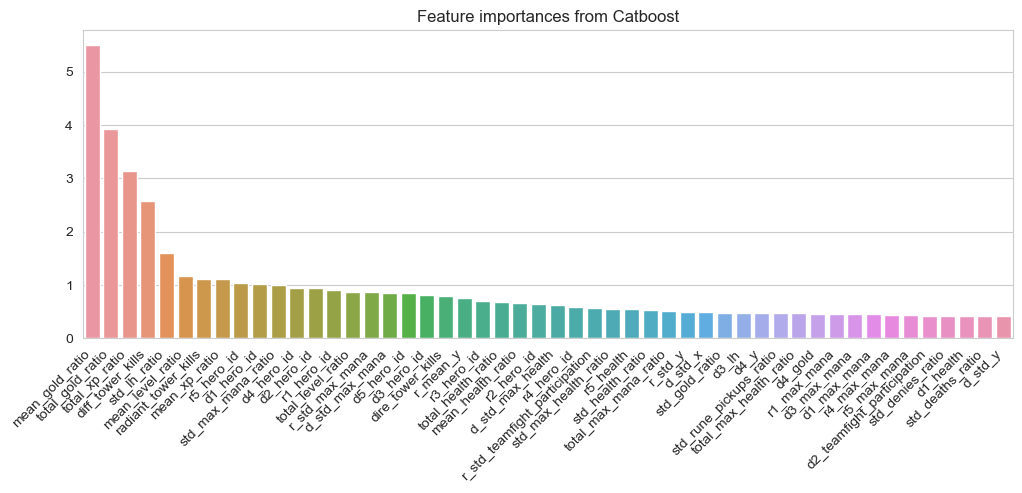

In [196]:
plt.figure(figsize=(12, 4))

indices = np.argsort(-cb_model.feature_importances_)
feature_names = train.columns 

sns.barplot(
    x=[feature_names[i] for i in indices][:50], 
    y=cb_model.feature_importances_[indices][:50]
)
plt.title("Feature importances from Catboost")
plt.xticks(rotation=45, ha="right")
plt.show()